### 0. Import Libraries / Functions

In [4]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

import math
import requests, json
from urllib.parse import quote

from keras.models import Model
from keras.layers import Input, LSTM, Dense
from keras.utils import to_categorical

### 1. Load Data

In [21]:
dataset = load_data('XRP', 1, 10000)

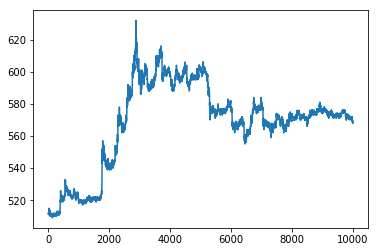

In [22]:
plt.plot(dataset[:,[6]].astype(float)) # todo : 플롯 스타팅 포인트(x) 바꿔그리기

### 2. Set constant values / hyperparameters

In [102]:
col=[6]
input_seq = 5
output_seq = 5
hidden = 128
padding = 50
batch_size = 5
epoch = 10

### 3. Process data / Split to train and test

In [116]:
#cardinality 세팅을 위한 데이터 패딩 처리
meta, data_origin, _, features, distance = feed_maker(dataset, col, scale=False)
data_padded = data_origin - distance
x1, x2, y = get_processed_data(data_padded, input_seq, output_seq, features)
#x1, x2, y = get_processed_data(data_origin, input_seq, output_seq, features)
train, test = split_data(x1, x2, y, test_portion=0.1)

ValueError: can only specify one unknown dimension

### 4. Build / Train Model

In [117]:
model, infenc, infdec = define_models(features, features, hidden)
model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['acc']) #메트릭 MAE로 바꿔서 결과 비교해 보기

In [118]:
hist = model.fit([train[0], train[1]], train[2], batch_size=batch_size, epochs=epoch, validation_split=0.1)

ValueError: Error when checking input: expected input_21 to have 3 dimensions, but got array with shape (8992, 5)

### 5. Show trained result

8992/8992 [==============================] - 1s 156us/step
Loss: 0.0025192874274962314 MAE: 0.005157824609017669


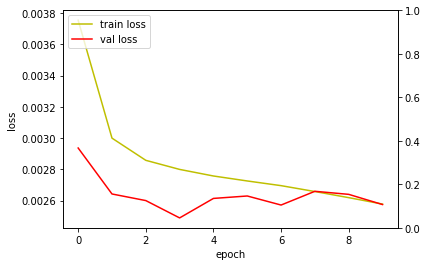

In [112]:
#results
test_model(model, [train[0], train[1]], train[2])

#graph
show_graph(hist)

### 6. Predict Future data using trained model

In [113]:
test_predict = predict_data(test[0])

In [114]:
total, correct = test_predict.shape[0], 0

for i in range(len(test_predict)):
    if np.array_equal(one_hot_decode(test[2][i]), one_hot_decode(test_predict[i])):
            correct += 1
print('Accuracy: %.2f%%' % (float(correct)/float(total)*100.0))

for i in range(10):
    print('X=%s y=%s, yhat=%s' % (one_hot_decode(test[0][i]), one_hot_decode(test[2][i]), one_hot_decode(test_predict[i])))

Accuracy: 9.11%
X=[116, 117, 117, 116, 115] y=[117, 117, 117, 116, 115], yhat=[115, 115, 115, 115, 114]
X=[117, 117, 116, 115, 117] y=[117, 117, 116, 115, 116], yhat=[117, 116, 116, 116, 116]
X=[117, 116, 115, 117, 117] y=[117, 116, 115, 116, 116], yhat=[117, 117, 117, 117, 116]
X=[116, 115, 117, 117, 117] y=[116, 115, 116, 116, 116], yhat=[117, 117, 117, 117, 117]
X=[115, 117, 117, 117, 116] y=[115, 116, 116, 116, 115], yhat=[116, 116, 116, 116, 116]
X=[117, 117, 117, 116, 115] y=[116, 116, 116, 115, 116], yhat=[115, 115, 115, 114, 114]
X=[117, 117, 116, 115, 116] y=[116, 116, 115, 116, 115], yhat=[116, 116, 116, 116, 116]
X=[117, 116, 115, 116, 116] y=[116, 115, 116, 115, 116], yhat=[116, 116, 116, 116, 116]
X=[116, 115, 116, 116, 116] y=[115, 116, 115, 116, 115], yhat=[116, 116, 116, 116, 116]
X=[115, 116, 116, 116, 115] y=[116, 115, 116, 115, 117], yhat=[115, 115, 115, 115, 115]


In [115]:
#new functions for seq_to_seq
#패딩된 데이터를 3개의 seq 데이터로 만들기
#왜 x2가 필요한가?
def get_processed_data(data, input_seq, output_seq, features):
    
    origin = list()
    for i in range(len(data)-output_seq +1):
        origin.append(data[i:i+input_seq].reshape(1,-1)[0])
    origin = np.array(origin)
    source = origin[:-output_seq]
    target = origin[input_seq:]
    target_in = np.concatenate([np.zeros((target.shape[0],1)),target[:,0:output_seq-1]],axis=1)

    source_encoded = to_categorical(source,num_classes=features)
    target_encoded = to_categorical(target,num_classes=features)
    target_in_encoded = to_categorical(target_in,num_classes=features)

    return source_encoded, target_in_encoded, target_encoded
#    return source, target_in, target

#원핫 디코딩
def one_hot_decode(encoded_seq):
    return [np.argmax(vector) for vector in encoded_seq]

#모델 생성
def define_models(n_input, n_output, n_units):
    
    #인코더 정의
    encoder_inputs = Input(shape=(None, n_input))
    encoder = LSTM(n_units, return_state=True)
    encoder_outputs, state_h, state_c = encoder(encoder_inputs)
    encoder_states = [state_h, state_c]
    
    #디코더 정의
    decoder_inputs = Input(shape=(None, n_output))
    decoder_lstm = LSTM(n_units, return_sequences=True, return_state=True)
    decoder_outputs, _, _ = decoder_lstm(decoder_inputs, initial_state=encoder_states)
    decoder_dense = Dense(n_output, activation='softmax')
    decoder_outputs = decoder_dense(decoder_outputs)
    model = Model([encoder_inputs, decoder_inputs], decoder_outputs)
    
    # define inference encoder
    encoder_model = Model(encoder_inputs, encoder_states)
    
    # define inference decoder
    decoder_state_input_h = Input(shape=(n_units,))
    decoder_state_input_c = Input(shape=(n_units,))
    decoder_states_inputs = [decoder_state_input_h, decoder_state_input_c]
    decoder_outputs, state_h, state_c = decoder_lstm(decoder_inputs, initial_state=decoder_states_inputs)
    decoder_states = [state_h, state_c]
    decoder_outputs = decoder_dense(decoder_outputs)
    decoder_model = Model([decoder_inputs] + decoder_states_inputs, [decoder_outputs] + decoder_states)
    
    # return all models
    return model, encoder_model, decoder_model

# 프레딕션
def predict_sequence(infenc, infdec, data, n_steps, features):
    
    state = infenc.predict(data)
    target_seq = np.array([0.0 for _ in range(features)]).reshape(1, 1, features)
    
    output = list()
    for t in range(n_steps):
        predict, h, c = infdec.predict([target_seq] + state)
        output.append(predict[0,0,:])
        state = [h, c]
        target_seq = predict
    return np.array(output)

def predict_data(data):
    res = list()
    
    for i in range(len(data)):
        predict = predict_sequence(infenc, infdec, data[i].reshape(1,data[i].shape[0], data[i].shape[1]), output_seq, features)
        res.append(predict)
    
    return np.array(res)

In [122]:
#old functions
def call_candle(currency, minutes, count, to=''):
    max_count = 100

    if count > max_count:
        iter_range = count // max_count
        iter_left = count % max_count
        total = []

        while iter_range:
            to_encoded = quote(to)
            URL = 'https://api.upbit.com/v1/candles/minutes/' + str(
                minutes) + '?market=KRW-' + currency + '&count=' + str(max_count) + '&to=' + to_encoded
            req = requests.get(URL)
            res = json.loads(req.text)

            iter_range -= 1
            to = res[-1]['candle_date_time_kst'] + '+09:00'
            total += res

        if iter_left > 0:
            to_encoded = quote(to)
            URL = 'https://api.upbit.com/v1/candles/minutes/' + str(
                minutes) + '?market=KRW-' + currency + '&count=' + str(iter_left) + '&to=' + to_encoded
            req = requests.get(URL)
            res = json.loads(req.text)
            total += res

        return total
    else:
        to_encoded = quote(to)
        URL = 'https://api.upbit.com/v1/candles/minutes/' + str(
            minutes) + '?market=KRW-' + currency + '&count=' + str(count) + '&to=' + to_encoded
        req = requests.get(URL)
        res = json.loads(req.text)
        res.reverse()

        return res
    
def load_data(currencies, mins, counts):
    #loading data
    data_origin = call_candle(currencies, minutes=mins , count=counts, to='2018-11-11T23:00:00+09:00')
    data_array = []
    for i in data_origin:
        data_array.append(list(i.values()))
    data = np.array(data_array)
    data = data[data[:,2].argsort()] #sort by time
    return data

#seq 용으로 커스텀. 무조건 3*2 6개의 결과가 나오도록 되어 있음.
def split_data(x1, x2, y, test_portion=0.1):
    test_size = int(len(x1) * test_portion)
    train_x1, test_x1 = x1[:-test_size], x1[-test_size:]
    train_x2, test_x2 = x2[:-test_size], x2[-test_size:]
    train_y, test_y = y[:-test_size], y[-test_size:]
    
    return (train_x1, train_x2, train_y), (test_x1, test_x2, test_y)

def feed_maker(data, col, scale=True, is_training=True, v=None):
    if is_training == True:
        v = {}
    x = {}
    
    #Missing Value 핸들링 : 각 값들을 median value로 채움
    if scale == True:
        for i in range(len(col)):
            if is_training == True:
                v[i] = get_metadata(data[:,col][:,i].astype(float))
            x[i] = scale_value(data[:,col][:,i].astype(float), v[i], scale=True)
    else:
        for i in range(len(col)):
            x[i] = data[:,col][:,i].astype(float)
    
    x_val = np.transpose(np.array(list(x.values())))
    y_val = x_val[:,[0]]
    
    data_min, data_max = np.min(x_val), np.max(x_val)
    features = int(data_max - data_min + (2*padding))
    distance = data_min - padding
        
    return v, x_val, y_val, features, distance

def get_metadata(feature):
    obj = {}
    obj['min'] = feature.min()
    obj['max'] = feature.max()
        
    return obj

def scale_value(feature, meta, scale):
    #수동 스케일러
    if scale == True:
        def minmaxScaler(data, datamin, datamax):
            numerator = data - datamin
            denominator = datamax - datamin
            return numerator / (denominator + 1e-8)
        
        return minmaxScaler(feature, meta['min'], meta['max'])

    else:
        pass
    
def show_graph(hist):
    fig, loss_ax = plt.subplots()

    acc_ax = loss_ax.twinx()

    loss_ax.plot(hist.history['loss'], 'y', label='train loss')
    loss_ax.plot(hist.history['val_loss'], 'r', label='val loss')

    #acc_ax.plot(hist.history['mean_absolute_error'], 'b', label='train mae')
    #acc_ax.plot(hist.history['val_mean_absolute_error'], 'g', label='val mae')

    loss_ax.set_xlabel('epoch')
    loss_ax.set_ylabel('loss')
    #acc_ax.set_ylabel('mean_absolute_error')

    loss_ax.legend(loc='upper left')
    #acc_ax.legend(loc='lower left')
    
def test_model(model, testX, testY):
    loss, metric = model.evaluate(testX, testY, verbose=1)
    print('Loss:',loss, 'Acc:', metric)